In [ ]:
#Further Analysis on the results of Pavlos Algorithm
#Considering the filtered alignment, how likelihoods and trees differ

In [1]:
# %load LuiseUtil.py
import os
import shutil
import math
from ete3 import Tree
from Bio import Phylo
import matplotlib
import matplotlib.pyplot as plt
from codecs import decode
import struct

from Bio import Phylo, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.AlignIO.PhylipIO import PhylipWriter


raxml_ng_path = './../../tools/raxml-ng/build/bin/raxml-ng'
standard_raxml_path = './../../tools/standard-RAxML-master/raxmlHPC-AVX '

tree_dir = 'data/trees/'
alignment_dir = 'data/language_alignments/'
sitelh_dir = 'data/siteLH/'
drawings_dir = 'output/drawings/'
weight_calibration_dir = 'data/weight_calibration/'
site_congruence_dir = 'data/site_congruence/'
lh_dir = 'data/lh/'
indices_dir = 'data/indices/'


#tree_space_name = 'space.trees'
geo_tree_name = "geo_duration.tree"
cognate_tree_name = "cognate_ie_compatible.tree"
cognate_ml_tree_name = "cognate_ml.tree"

morpho_alignment_name = "morpho.phy"



def read_trees_from_ete(tree_set_names):
    trees = []
    for tree_set in tree_set_names:
        l_file = open(tree_dir + tree_set, 'r')
        lines = l_file.readlines()
        for line in lines:
            trees.append(Tree(line))
    return trees

#def read_tree_space_ete():
#    return read_trees_from_ete([tree_space_name])


def eliminate_topological_duplicates_ete(tree_set_names, out_file_name):
    unique_list = []
    tree_set_ete = read_trees_from_ete(tree_set_names)
    i = 0
    for t1 in tree_set_ete:
        unique = True
        for t2 in unique_list:
            rf = rf_distance_ete(t1, t2)
            if rf == 0:
                unique = False
                break
        if unique:
            unique_list.append(t1)
        i = i + 1
    file_name = tree_dir + out_file_name
    with open(file_name, 'w+') as tree_file:
        for tree in unique_list:
            tree_file.write(tree.write()+"\n")
    print(file_name + " created")

def set_neg_branches_zero_ete(tree):
    for node in tree.traverse("postorder"):
        if node.dist < 0:
            node.dist = 0
    return tree

def set_neg_branches_zero(tree_set_name):
    trees = read_trees_from_ete([tree_set_name])
    for tree in trees:
        tree = set_neg_branches_zero_ete(tree)
    file_name = tree_dir + (".".join(tree_set_name.split(".")[:-1])) + ".nonneg.trees"
    with open(file_name, 'w+') as tree_file:
        for tree in trees:
            tree_file.write(tree.write()+"\n")



#def create_tree_space_from(tree_set_names):
#    tree_space_ete = read_trees_from_ete(tree_set_names)
#    file_name = tree_dir + tree_space_name
#    with open(file_name, 'w+') as tree_file:
#        for tree in tree_space_ete:
#            tree_file.write(tree.write()+"\n")
#    print(str(len(tree_space_ete)) + " trees written to " + file_name)

def read_geo_tree_ete():
    return Tree(tree_dir + geo_tree_name)

def read_cognate_tree_ete():
    return Tree(tree_dir + cognate_tree_name)

def rf_distance_ete(t1, t2):
    rf, max_rf, common_leaves, parts_t1, parts_t2,discard_t1, discart_t2 = t1.robinson_foulds(t2, unrooted_trees = True)
    if max_rf == 0:
        print("?!")
        return 0
    return rf/max_rf

def rf_distances_ete(ref_tree, tree_set):
    distances = []
    for tree in tree_set:
        distances.append(rf_distance_ete(ref_tree, tree))
    return distances


def calculate_rf_distances_raxml(ref_tree_name, tree_set_names):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    dir_string = tree_dir + ref_tree_name
    for tree_set in tree_set_names:
        dir_string = dir_string + tree_dir + tree_set
    os.system("cat " + dir_string + " > temp/all.trees")
    os.system(raxml_ng_path + " --rfdist --tree temp/all.trees --prefix temp/foo > temp/bar.txt")
    l_file = open('temp/foo.raxml.rfDistances', 'r')
    lines = l_file.readlines()
    i = 0
    line = lines[i].split("\t")
    distances = []
    while(line[0] == '0'):
        distances.append(float(line[3]))
        i+=1
        line = lines[i].split("\t")
    shutil.rmtree("temp/", ignore_errors=True)
    return distances


def evaluate_lh_raxml(tree_name, alignment_name, optimize = True):
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix foo --nofiles' +
              optimize_string + '> out.txt')
    l_file = open('out.txt', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    os.remove("out.txt")
    return lh







def calculate_site_lh_raxml_ete(tree_ete, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    tree_ete.write(outfile="temp/foo.tree")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree temp/foo.tree --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    #siteLH = [float(data[i]) for i in range(5, len(data))]
    siteLH = [data[i] for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]




def print_tree_with_phylo(tree_name, save = False):
    tree = Phylo.read(tree_dir + tree_name, "newick")
    tree.ladderize()
    fig = plt.figure(figsize=(10, 10), dpi=100)
    axes = fig.add_subplot(1, 1, 1)
    axes.set_title(tree_name)
    Phylo.draw(tree, axes=axes, do_show=False)
    if save:
        plt.savefig(drawings_dir + tree_name + '.png', dpi=fig.dpi)


def fix_beast_output(tree_set_name):
    beast_file = open(tree_dir + tree_set_name, 'r')
    lines = beast_file.readlines()
    i = 0
    while not lines[i].startswith("\tTranslate"):
        i = i+1
    translate = []
    while not lines[i].startswith(";"):
        if lines[i].endswith(",\n"):
            translate.append(lines[i].split(" ")[-1][:-2])
        else:
            translate.append(lines[i].split(" ")[-1][:-1])
        i=i+1
    i = i+1
    with open(tree_dir + rm_end(tree_set_name) + "_fixed.trees" , 'w+') as fixed_file:
        for j in range(i, len(lines)-1):
            tree = Tree(lines[j].split(" ")[-1])
            for leaf in tree.iter_leaves():
                leaf.name = translate[int(leaf.name)]
            fixed_file.write(tree.write() + "\n")

def rm_end(file_name):
    return '.'.join(file_name.split('.') [:-1])

def lh_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '.lh'

def lh_raw_file_name(tree_set_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return lh_dir + rm_end(alignment_name) + '_' + rm_end(tree_set_name)  + optimize_string + '_raw.lh'


def site_lh_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '.raxml.siteLH'

def site_lh_raw_file_name(tree_name, alignment_name, optimize):
    optimize_string = "_opt-branches="
    if optimize:
        optimize_string = optimize_string + "on"
    else:
        optimize_string = optimize_string + "off"
    return sitelh_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + optimize_string + '_raw.raxml.siteLH'

def weight_calibration_file_name(tree_name, alignment_name):
    return weight_calibration_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.weightCalibration'

def site_congruence_file_name(tree_name, alignment_name):
    return site_congruence_dir + rm_end(alignment_name) + '_' + rm_end(tree_name)  + '.raxml.siteCongruence'

def optimized_tree_file_name(tree_name, alignment_name):
    return tree_dir + rm_end(tree_name) + '_optimized_' + rm_end(alignment_name)  + '.tree'

def ml_trees_file_name(alignment_name, start_trees = ""):
    if start_trees == "":
        return tree_dir + rm_end(alignment_name) + ".raxml.mlTrees"
    else:
        return tree_dir + rm_end(alignment_name) + "_" + start_trees + ".raxml.mlTrees"

def best_tree_file_name(alignment_name, start_trees = ""):
    if start_trees == "":
        return tree_dir + rm_end(alignment_name) + ".raxml.bestTree"
    else:
        return tree_dir + rm_end(alignment_name) + "_" + start_trees + ".raxml.bestTree"


def read_lhs(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_lhs_raw(tree_set_name, alignment_name, optimize):
    lhs = []
    site_lhs = []
    with open(lh_raw_file_name(tree_set_name, alignment_name, optimize) , 'r') as file:
        lines = file.read().split("\n")
    for line in lines[:-1]:
        line_data = line.split("\t")
        lhs.append(float(line_data[0]))
        site_lhs.append([bin_to_float(el) for el in line_data[1].split(" ")[:-1]])
    return (lhs, site_lhs)

def read_site_lh(tree_name, alignment_name, optimize):
    with open(site_lh_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [float(data[i]) for i in range(5, len(data))]

def read_site_lh_raw(tree_name, alignment_name, optimize):
    with open(site_lh_raw_file_name(tree_name, alignment_name, optimize) , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    return [bin_to_float(data[i]) for i in range(5, len(data))]

def read_weight_calibration(tree_name, alignment_name):
    with open(weight_calibration_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split(" ")
    return [int(data[i]) for i in range(len(data) - 1)]

def read_site_congruence(tree_name, alignment_name):
    with open(site_congruence_file_name(tree_name, alignment_name) , 'r') as file:
        data = file.read().split("\n")
    return [float(data[i].split(" ")[1]) for i in range(len(data) - 1)]

def read_optimized_tree(tree_name, alignment_name):
    return Tree(optimized_tree_file_name(tree_name, alignment_name))

def read_ml_trees(alignment_name, start_trees = ""):
    tree_file = open(ml_trees_file_name(alignment_name, start_trees))
    return [Tree(line[:-1]) for line in tree_file.readlines()]

def read_best_tree(alignment_name, start_trees = ""):
    tree_file = open(best_tree_file_name(alignment_name, start_trees))
    return Tree(tree_file.readlines()[0][:-1])

def calculate_lhs_raxml(tree_set_name, alignment_name, optimize = False):
    tree_set = read_trees_from_ete([tree_set_name])
    results = [calculate_site_lh_raxml_ete(tree, alignment_name, optimize) for tree in tree_set]
    with open(lh_raw_file_name(tree_set_name, alignment_name, optimize), 'w+') as out_file:
        for result in results:
            out_file.write(str(result[0]))
            out_file.write("\t")
            for site_lh in result[1]:
                #out_file.write(str(site_lh))
                out_file.write(site_lh)
                out_file.write(" ")
            out_file.write("\n")

def calculate_site_lh_raxml(tree_name, alignment_name, optimize= True):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    optimize_string = ""
    if not optimize:
        optimize_string = " --opt-branches off "
    os.system(raxml_ng_path + ' --sitelh --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' +
              optimize_string + '> temp/bar.txt')
    l_file = open('temp/foo.raxml.log', 'r')
    lines = l_file.readlines()
    lh = 0
    for line in lines:
        if(line.startswith('Final LogLikelihood:')):
            lh = float(line.split(" ")[2].strip())
    #os.system("cat temp/foo.raxml.siteLH > " + site_lh_file_name(tree_name, alignment_name, optimize))
    os.system("cat temp/foo.raxml.siteLH > " + site_lh_raw_file_name(tree_name, alignment_name, optimize))
    with open('temp/foo.raxml.siteLH' , 'r') as file:
        data = (file.read().replace('\n', '')).split(" ")
    #siteLH = [float(data[i]) for i in range(5, len(data))]
    siteLH = [data[i] for i in range(5, len(data))]
    shutil.rmtree("temp/", ignore_errors=True)
    return [lh, siteLH]

def calculate_weight_calibration_raxml(tree_name, alignment_name):
    os.system(standard_raxml_path + ' -f u -p 12345 -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n calibration > bar.txt')
    os.system('cat RAxML_weights.calibration > '
              + weight_calibration_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_weights.calibration')
    os.remove('RAxML_info.calibration')

def calculate_site_congruence_raxml(tree_name, alignment_name):
    os.system(standard_raxml_path + ' -f S -t ' + tree_dir + tree_name +
              ' -m BINGAMMA -s ' + alignment_dir + alignment_name +
              ' -n congruence > bar.txt')
    os.system('cat RAxML_SiteSpecificPlacementBias.congruence > '
              + site_congruence_file_name(tree_name, alignment_name))
    os.remove('bar.txt')
    os.remove('RAxML_SiteSpecificPlacementBias.congruence')
    os.remove('RAxML_info.congruence')

def calculate_optimized_tree_raxml(tree_name, alignment_name):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    os.system(raxml_ng_path + ' --evaluate --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --model BIN+G --tree '  + tree_dir + tree_name +  ' --prefix temp/foo ' + '> out.txt')
    os.system('cat temp/foo.raxml.bestTree > ' + tree_dir + rm_end(tree_name) + "_optimized_" + rm_end(alignment_name) + '.tree')
    shutil.rmtree("temp/", ignore_errors=True)


def calculate_ml_trees_raxml(alignment_name, start_trees = ""):
    shutil.rmtree("temp/", ignore_errors=True)
    os.mkdir("temp/")
    if start_trees == "":
        os.system(raxml_ng_path + ' --msa ' + alignment_dir + alignment_name +
            ' --threads 2 --seed 2 --model BIN+G --prefix temp/foo > temp/bar.txt')
    else:
        os.system(raxml_ng_path + ' --msa ' + alignment_dir + alignment_name +
            ' --tree ' + start_trees +
            ' --threads 2 --seed 2 --model BIN+G --prefix temp/foo > temp/bar.txt')
    os.system('cat temp/foo.raxml.mlTrees > ' + ml_trees_file_name(alignment_name, start_trees))
    os.system('cat temp/foo.raxml.bestTree > ' + best_tree_file_name(alignment_name, start_trees))



def get_site_lh(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_file_name(tree_name, alignment_name, optimize)):
        print("Currently not possible, use site_lh_raw")
        #calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh(tree_name, alignment_name, optimize)

def get_site_lh_raw(tree_name, alignment_name, optimize):
    if not os.path.isfile(site_lh_raw_file_name(tree_name, alignment_name, optimize)):
        calculate_site_lh_raxml(tree_name, alignment_name, optimize)
    return read_site_lh_raw(tree_name, alignment_name, optimize)


def get_weight_calibration(tree_name, alignment_name):
    if not os.path.isfile(weight_calibration_file_name(tree_name, alignment_name)):
        calculate_weight_calibration_raxml(tree_name, alignment_name)
    return read_weight_calibration(tree_name, alignment_name)

def get_site_congruence(tree_name, alignment_name):
    if not os.path.isfile(site_congruence_file_name(tree_name, alignment_name)):
        calculate_site_congruence_raxml(tree_name, alignment_name)
    return read_site_congruence(tree_name, alignment_name)

def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)

def get_double_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    optimized_tree_name = optimized_tree_file_name(tree_name, alignment_name).split('/')[-1]
    if not os.path.isfile(optimized_tree_file_name(optimized_tree_name, alignment_name)):
        calculate_optimized_tree_raxml(optimized_tree_name, alignment_name)
    return read_optimized_tree(optimized_tree_name, alignment_name)


def get_optimized_tree(tree_name, alignment_name):
    if not os.path.isfile(optimized_tree_file_name(tree_name, alignment_name)):
        calculate_optimized_tree_raxml(tree_name, alignment_name)
    return read_optimized_tree(tree_name, alignment_name)


def get_lhs(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_file_name(tree_set_name, alignment_name, optimize)):
        #calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
        print("Currently not possible, use lhs_raw")
    return read_lhs(tree_set_name, alignment_name, optimize)

def get_lhs_raw(tree_set_name, alignment_name, optimize):
    if not os.path.isfile(lh_raw_file_name(tree_set_name, alignment_name, optimize)):
        calculate_lhs_raxml(tree_set_name, alignment_name, optimize)
    return read_lhs_raw(tree_set_name, alignment_name, optimize)


def get_ml_trees(alignment_name, start_trees = ""):
    if not os.path.isfile(ml_trees_file_name(alignment_name, start_trees)):
        calculate_ml_trees_raxml(alignment_name, start_trees)
    return read_ml_trees(alignment_name, start_trees)

def get_best_tree(alignment_name, start_trees = ""):
    if not os.path.isfile(best_tree_file_name(alignment_name, start_trees)):
        calculate_ml_trees_raxml(alignment_name, start_trees)
    return read_best_tree(alignment_name, start_trees)





def average_branch_length(tree_set):
    avg = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            avg = avg + node.dist
            cnt = cnt + 1
    avg = avg / cnt
    return avg



def interval_branch_length(tree_set):
    lower = 1
    upper = 0
    for tree in tree_set:
        for node in tree.traverse():
            lower = min(lower, node.dist)
            upper = max(upper, node.dist)
    return (lower, upper)



def variance_branch_length(tree_set):
    avg = average_branch_length(tree_set)
    var = 0
    cnt = 0
    for tree in tree_set:
        for node in tree.traverse():
            diff = node.dist - avg
            var = var + (diff * diff)
            cnt = cnt + 1
    return var / cnt


def bin_to_float(b):
    return struct.unpack('>d', decode('%%0%dx' % (8 << 1) % int(b, 2), 'hex')[-8:])[0]


def rf_dist_matrix(tree_dict):
    for i, name1 in enumerate(tree_dict):
        for j, name2 in enumerate(tree_dict):
            if name2 <= name1:
                continue
            rf_str = str(rf_distance_ete(tree_dict[name1], tree_dict[name2]))
            print("RF distance of " + name1 + " to " + name2 + ": " + rf_str)













In [2]:
def convert_pavlos_indices(indices_file_name):
    pavlos_indices = [int(l) for l in open(indices_dir + indices_file_name).readlines()]
    inds_to_use = [int(l) for l in open(indices_dir + "indsToUse").readlines()]
    with open(indices_dir + indices_file_name + "_converted", "w+") as inds_file:
        for ind in pavlos_indices:
            true_ind = inds_to_use[ind-1]-1
            inds_file.write(str(true_ind) + "\n")
            
def filter_align(alignment_name, indices_file_name, convert, fix = True):
    filtered_alignment_name = alignment_name.split(".")[0] + "_filtered_" + indices_file_name + ".phy"
    if os.path.isfile(alignment_dir + filtered_alignment_name):
        return filtered_alignment_name
    if convert:
        convert_pavlos_indices(indices_file_name)
        indices_file_name = indices_file_name + "_converted"
    align = AlignIO.read(alignment_dir + alignment_name, "phylip")
    if fix:
        # fixing process only required if AlignIO has problems with format
        records = []
        for i in range(0, len(align)):
            full_sequence = align[i].id.split(" ")[-1] + align[i].seq
            records.append(SeqRecord(Seq(full_sequence), id=align[i].id.split(" ")[0]))
        align = MultipleSeqAlignment(records, annotations={}, column_annotations={})
    
    indices_file = open(indices_dir + indices_file_name)
    indices = [int(line[:-1]) for line in indices_file.readlines()]
    idx = indices[0]
    filtered_align = align[:, idx:idx+1]
    for i in range(1, len(indices)):
        idx = indices[i]
        filtered_align = filtered_align + align[:, idx:idx+1]

    with open(alignment_dir + filtered_alignment_name,"w+") as f:
        writer = PhylipWriter(f)
        writer.write_alignment(filtered_align)
    return filtered_alignment_name


#filtered_alignment_name = filter_align(morpho_alignment_name, "best_site_lh_cognate_morpho", False)
#filtered_alignment_name = filter_align(morpho_alignment_name, "best_weight_calibration_cognate_morpho", False)
#filtered_alignment_name = filter_align(morpho_alignment_name, "large_step10000000", True)
#filtered_alignment_name = filter_align(morpho_alignment_name, "union_best_nj", True)
#filtered_alignment_name = filter_align(morpho_alignment_name, "intersect_best_nj", True)

#filtered_alignment_name = filter_align(morpho_alignment_name, "pars_large_step9630000", True)
#filtered_alignment_name = filter_align(morpho_alignment_name, "pars_large_step10000000", True)
filtered_alignment_name = filter_align(morpho_alignment_name, "ml_large_step1260000", True)

[0.8372093023255814, 0.8604651162790697, 0.8372093023255814, 0.8604651162790697, 0.8604651162790697, 0.8604651162790697, 0.8604651162790697, 0.8604651162790697, 0.7906976744186046, 0.8604651162790697, 0.8372093023255814, 0.7906976744186046, 0.8604651162790697, 0.8604651162790697, 0.8604651162790697, 0.8604651162790697, 0.813953488372093, 0.8604651162790697, 0.8604651162790697, 0.813953488372093]
morpho.phy
Likelihood of best tree: -3919.964468
Likelihood of reference tree: -4214.114167
Difference: -0.07503886869415366
Avg rf distance of mlTrees to reference tree: 0.8453488372093021
Dist of ml tree to reference tree: 0.8372093023255814

[0.8837209302325582, 0.8837209302325582, 0.8837209302325582, 0.8604651162790697, 0.8837209302325582, 0.8372093023255814, 0.8837209302325582, 0.8837209302325582, 0.8837209302325582, 0.8837209302325582, 0.8604651162790697, 0.8372093023255814, 0.8372093023255814, 0.8837209302325582, 0.8837209302325582, 0.8604651162790697, 0.8604651162790697, 0.8604651162790

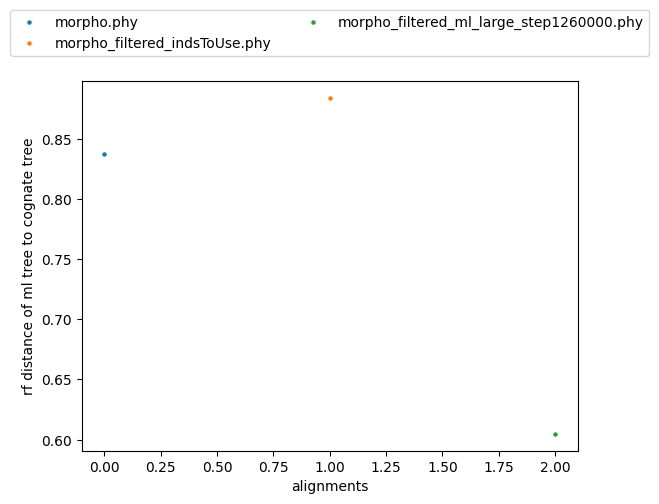

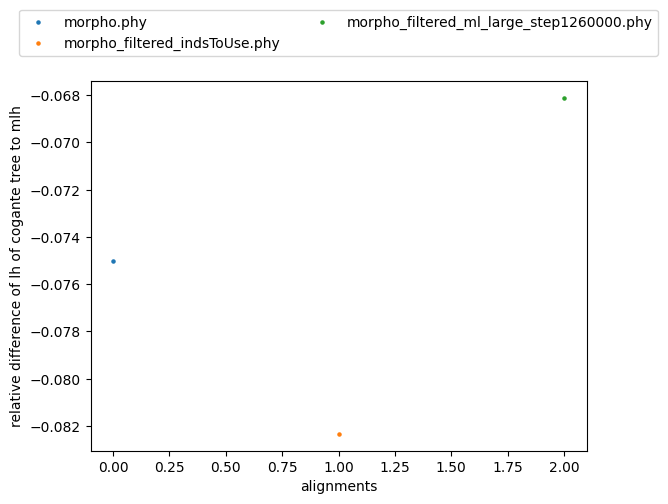

In [12]:

def reference_tree_analysis(alignment_name, reference_tree_name):
    reference_tree = Tree(tree_dir + reference_tree_name)
    
    reference_lh = evaluate_lh_raxml(reference_tree_name, alignment_name)
    ml_trees = get_ml_trees(alignment_name)
    best_tree = get_best_tree(alignment_name)
    lh = calculate_site_lh_raxml_ete(best_tree, alignment_name, optimize=False)[0]
    #diff = abs(reference_lh - lh)/abs(lh)
    diff = 1 - (reference_lh / lh)
    
    rf_dists = rf_distances_ete(reference_tree, ml_trees)
    print(rf_dists)
    avg_rf_dist = sum(rf_dists)/len(rf_dists)
    dist = rf_distance_ete(best_tree, reference_tree)
    print(alignment_name)
    print("Likelihood of best tree: " + str(lh))
    print("Likelihood of reference tree: " + str(reference_lh))
    print("Difference: " + str(diff))
    print("Avg rf distance of mlTrees to reference tree: " + str(avg_rf_dist))
    print("Dist of ml tree to reference tree: " + str(dist))
    print("")
    
    return diff, dist


def analyse_alignments(alignment_names):
    diffs = []
    dists = []
    for alignment_name in alignment_names:
        diff, dist = reference_tree_analysis(alignment_name, cognate_tree_name)
        diffs.append(diff)
        dists.append(dist)
    fig, ax = plt.subplots()
    for i in range(len(alignment_names)):
        plt.scatter([i], dists[i], s=5, label = alignment_names[i])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    plt.xlabel("alignments")
    plt.ylabel("rf distance of ml tree to cognate tree")
    plt.show()
    
    fig, ax = plt.subplots()
    for i in range(len(alignment_names)):
        plt.scatter([i], diffs[i], s=5, label = alignment_names[i])
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    plt.xlabel("alignments")
    plt.ylabel("relative difference of lh of cogante tree to mlh")
    plt.show()





alignment_names = ["morpho.phy",
                   "morpho_filtered_indsToUse.phy",
                    #"morpho_filtered_best_site_lh_cognate_morpho.phy", 
                   #"morpho_filtered_best_weight_calibration_cognate_morpho.phy", 
                   #"morpho_filtered_intersect_best_nj.phy",
                  #"morpho_filtered_union_best_nj.phy",
                  #"morpho_filtered_large_step10000000.phy",
                   #"morpho_filtered_large_step9990000.phy",
                   #"morpho_filtered_large_step9980000.phy", 
                   #"morpho_filtered_large_step9970000.phy", 
                   #"morpho_filtered_large_step9960000.phy", 
                   #"morpho_filtered_large_step9950000.phy", 
                   #"morpho_filtered_large_step9940000.phy", 
                   #"morpho_filtered_large_step9930000.phy",
                   #"morpho_filtered_large_step9920000.phy"
                   #"morpho_filtered_pars_large_step10000000.phy",
                   #"morpho_filtered_pars_large_step9630000.phy",
                   "morpho_filtered_ml_large_step1260000.phy",
]



analyse_alignments(alignment_names)

In [4]:
#print_tree_with_phylo(cognate_tree_name)
#print_tree_with_phylo("morpho_filtered_best_site_lh_cognate_morpho.raxml.bestTree")

In [5]:
def compare_index_sets(file_name1, file_name2):
    inds1 = [int(l) for l in open(indices_dir + file_name1).readlines()]
    inds2 = [int(l) for l in open(indices_dir + file_name2).readlines()]
    inds1.sort()
    inds2.sort()
    i = 0
    j = 0
    intersect = []
    only1 = []
    only2 = []
    while i < len(inds1) and j < len(inds2):
        if inds1[i] == inds2[j]:
            intersect.append(inds1[i])
            i = i + 1
            j = j + 1
        elif inds1[i] < inds2[j]:
            only1.append(inds1[i])
            i = i + 1
        else:
            only2.append(inds2[j])
            j = j + 1
    for k in range(i, len(inds1)):
        only1.append(inds1[k])
    for k in range(j, len(inds2)):
        only2.append(inds2[k])
    print("Intersect: " + str(intersect))
    print("Only 1: " + str(only1))
    print("Only 2: " + str(only2))


#compare_index_sets("union_best_nj_converted", "best_site_lh_cognate_morpho")
#compare_index_sets("union_best_nj_converted", "best_weight_calibration_cognate_morpho")
#compare_index_sets("best_site_lh_cognate_morpho, "best_weight_calibration_cognate_morpho")
#compare_index_sets("indsToUse_converted", "best_site_lh_cognate_morpho")
compare_index_sets("union_best_nj_converted", "pars_large_step10000000_converted")

Intersect: [12, 19, 38, 51, 72, 76, 77, 82, 93, 96, 108, 112, 113, 116, 126, 143, 175, 176, 178, 188, 189, 190, 211, 213, 218, 219, 224, 233, 251, 258, 259, 278, 282, 284, 287, 293, 298, 320, 340, 347, 363, 369, 370, 388, 391, 403, 412]
Only 1: [18, 52, 61, 71, 74, 83, 88, 89, 117, 118, 119, 125, 128, 132, 152, 155, 179, 187, 207, 214, 225, 235, 241, 304, 321, 328, 338, 346, 376, 389, 390, 410, 411]
Only 2: [8, 33, 36, 40, 49, 60, 67, 86, 87, 91, 98, 110, 120, 121, 131, 134, 140, 141, 142, 145, 154, 177, 193, 194, 195, 197, 199, 204, 205, 210, 212, 223, 236, 240, 242, 243, 244, 245, 247, 252, 253, 255, 275, 276, 279, 280, 295, 296, 299, 300, 302, 306, 309, 313, 373, 377, 381, 382, 392, 400, 401, 415, 418, 419, 423, 424]


In [6]:
def create_union(index_file_names, union_suffix):
    u = set()
    for file_name in index_file_names:
        inds = set([int(l) for l in open(indices_dir + file_name).readlines()])
        u = u.union(inds)
    l = list(u)
    l.sort()
    with open(indices_dir + "union_" + union_suffix, "w+") as inds_file:
        for ind in l:
            inds_file.write(str(ind) + "\n")
            
            
def create_intersect(index_file_names, intersect_suffix):
    i = []
    init = True
    for file_name in index_file_names:
        inds = set([int(l) for l in open(indices_dir + file_name).readlines()])
        if init:
            i = inds
            init =  False
        else:
            indsToRemove = []
            for el in i:
                if not el in inds:
                    indsToRemove.append(el)
            for el in indsToRemove:
                i.remove(el)
    l = list(i)
    l.sort()
    with open(indices_dir + "intersect_" + intersect_suffix, "w+") as inds_file:
        for ind in l:
            inds_file.write(str(ind) + "\n")

def meta_sets(index_file_names):
    u = set()
    i = []
    w = {}
    init = True
    for file_name in index_file_names:
        inds = set([int(l) for l in open(indices_dir + file_name).readlines()])
        print("Set size: " + str(len(inds)))
        u = u.union(inds)
        if init:
            i = inds
            init =  False
        else:
            indsToRemove = []
            for el in i:
                if not el in inds:
                    indsToRemove.append(el)
            for el in indsToRemove:
                i.remove(el)
        for el in inds:
            if el in w:
                w[el] = w[el] + (1/len(index_file_names))
            else:
                w[el] = (1/len(index_file_names))
    print("Union size: " + str(len(u)))
    print("Intersect size: " + str(len(i)))
    #print(w)
    
    
#index_file_names = ["large_step10000000", "large_step9990000", "large_step9980000", "large_step9970000", 
#                    "large_step9960000", "large_step9950000", "large_step9940000", "large_step9930000",
#                    "large_step9920000"]

index_file_names = ["union_best_nj", "pars_large_step9630000"]
meta_sets(index_file_names)
index_file_names = ["pars_large_step10000000", "union_best_nj"]
#index_file_names = ["pars_large_step10000000", "pars_large_step9630000"]
meta_sets(index_file_names)
#create_union(index_file_names, "best_nj")
#create_intersect(index_file_names, "best_nj")

Set size: 80
Set size: 115
Union size: 149
Intersect size: 46
Set size: 113
Set size: 80
Union size: 146
Intersect size: 47


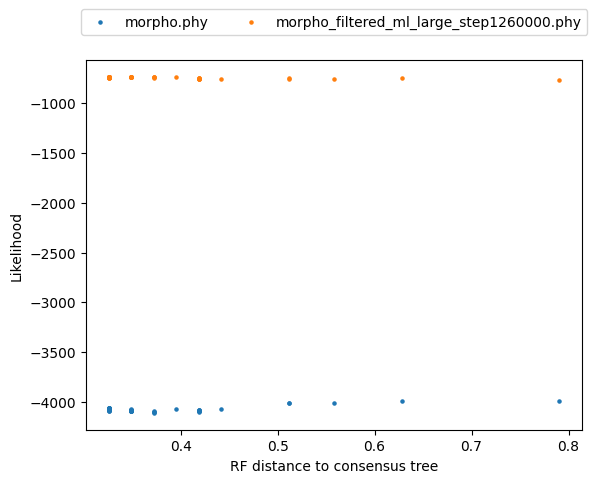

In [7]:


def lh_and_cognate_distance(tree_set_names, alignment_names):
    trees = read_trees_from_ete(tree_set_names)
    cognate_tree = Tree(tree_dir + cognate_tree_name)
    rfs = rf_distances_ete(cognate_tree, trees)
    #rfs = [0] + rfs
    lh_matrix = []
    for alignment_name in alignment_names:
        lhs = []
        for tree_set_name in tree_set_names:
            lhs+= get_lhs_raw(tree_set_name, alignment_name, True)[0]
        cognate_lh = evaluate_lh_raxml(cognate_tree_name, alignment_name, optimize = False)
        #lhs = [cognate_lh] + lhs
        lh_matrix.append(lhs)
        
        
    fig, ax = plt.subplots()
    for i in range(len(alignment_names)):
        #print(alignment_names[i])
        plt.scatter(rfs, lh_matrix[i], s=5, label = alignment_names[i])
        #plt.xlabel("rf distance to cognate tree")
        #plt.ylabel("lh with alignment")
        #plt.show()

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
    plt.xlabel("RF distance to consensus tree")
    plt.ylabel("Likelihood")
    plt.show()

lh_and_cognate_distance([
                                    #"cognate_neighbors_90_sample.trees", 
                                     #"all.trees",
                                    "pavlos_ml.trees"
                                        ], 
                        
                                        [
                                        "morpho.phy", 
                                       # "morpho_filtered_best_site_lh_cognate_morpho.phy", 
                                       # "morpho_filtered_best_weight_calibration_cognate_morpho.phy"])
                                       # "morpho_filtered_intersect_best_nj.phy",
                                       #"morpho_filtered_union_best_nj.phy",
                                       #"morpho_filtered_large_step10000000.phy",
                                       # "morpho_filtered_pars_large_step10000000.phy",
                                       "morpho_filtered_ml_large_step1260000.phy"
                                           ])

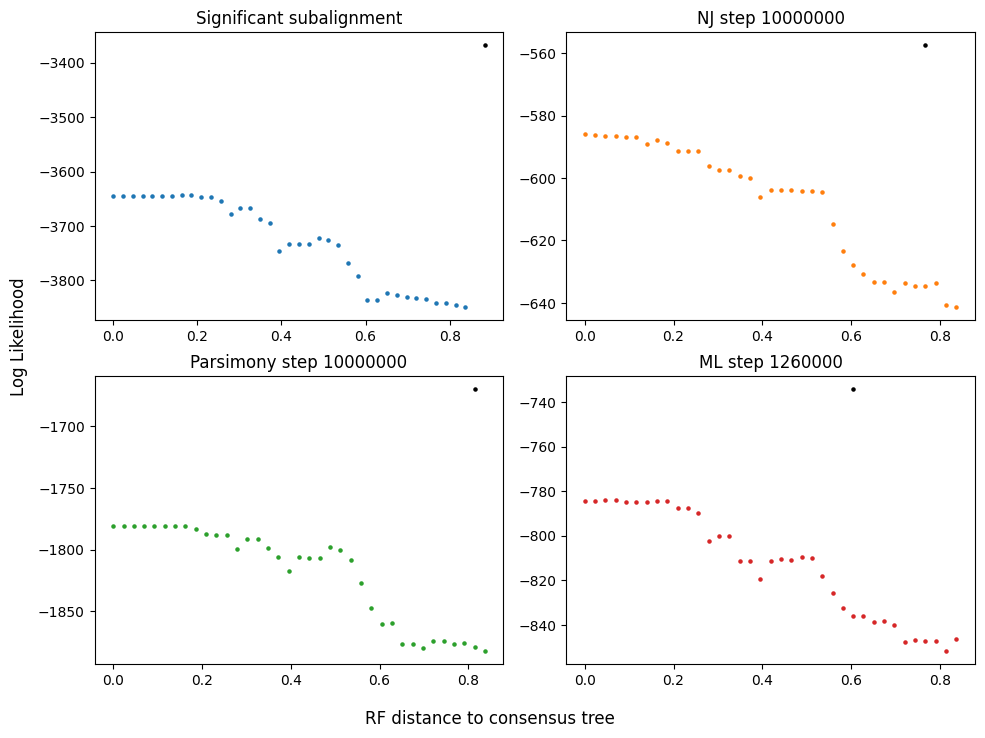

Rank Correlations
Significant subalignment & NJ step 10000000 & 0.9570886676149832\\
Significant subalignment & Parsimony step 10000000 & 0.9585111427216689\\
Significant subalignment & ML step 1260000 & 0.9599336178283546\\
NJ step 10000000 & Parsimony step 10000000 & 0.9720246562351824\\
NJ step 10000000 & ML step 1260000 & 0.9724988146040776\\
Parsimony step 10000000 & ML step 1260000 & 0.9706021811284967\\


In [9]:
from matplotlib.cm import get_cmap
from scipy import stats

def lh_and_cognate_distance(tree_set_names, names):
    colors = get_cmap("tab10").colors
    trees = read_trees_from_ete(tree_set_names)
    cognate_tree = Tree(tree_dir + cognate_tree_name)
    rfs = rf_distances_ete(cognate_tree, trees)
    #rfs = [0] + rfs
    max_lhs = []
    rfs_ml_trees = []
    lh_matrix = []
    for (alignment_name, _, _) in names:
        lhs = []
        for tree_set_name in tree_set_names:
            lhs+= get_lhs_raw(tree_set_name, alignment_name, True)[0]
        cognate_lh = evaluate_lh_raxml(cognate_tree_name, alignment_name, optimize = False)
        #lhs = [cognate_lh] + lhs
        lh_matrix.append(lhs)
        
        best_tree = get_best_tree(alignment_name)
        max_lhs.append(calculate_site_lh_raxml_ete(best_tree, alignment_name, optimize=False)[0])
        rfs_ml_trees.append(rf_distance_ete(best_tree, cognate_tree))
 
    num_plots = len(names)
    num_rows = num_plots//2 + num_plots%2
    fig, arr = plt.subplots(num_rows, 2, figsize=(10, num_rows*4)) 
    for i in range(num_plots):
        y = i%2
        if num_plots > 2:
            x = i//2
            arr[x,y].scatter(rfs, lh_matrix[i], s=5, color=colors[names[i][2]])
            arr[x,y].scatter(rfs_ml_trees[i], max_lhs[i], s=5, color='black')
            arr[x,y].set_title(names[i][1])
        else:
            arr[y].scatter(rfs, lh_matrix[i], s=5, color=colors[names[i][2]])
            arr[y].scatter(rfs_ml_trees[i], max_lhs[i], s=5, color='black')
            arr[y].set_title(names[i][1])
    fig.supxlabel('RF distance to consensus tree')
    fig.supylabel('Log Likelihood')
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()
    print("Rank Correlations")
    for i in range(num_plots):
        for j in range(i+1, num_plots):
            res = stats.spearmanr(lh_matrix[i], lh_matrix[j])[0]
            print(names[i][1] + " & " + names[j][1] + " & " + str(res) + "\\\\")

lh_and_cognate_distance([
                        "cognate_neighbors_90_sample.trees", 
                        #"all.trees",
                        #"pavlos_nj.trees",
                        #"pavlos_pars.trees",
                        #"pavlos_ml.trees"
                        ],[
                        #("morpho.phy", "Full alignment", 0), 
                        ("morpho_filtered_indsToUse.phy", "Significant subalignment", 0),
                        ("morpho_filtered_large_step10000000.phy", "NJ step 10000000", 1),
                        ("morpho_filtered_pars_large_step10000000.phy", "Parsimony step 10000000", 2),
                        ("morpho_filtered_ml_large_step1260000.phy", "ML step 1260000", 3)
                        ])